
# Part 1 - Loading the dataset

In [1]:
import fixmat
memoryI, meta1 = fixmat.load('Memory_I_raw.hdf', 'Memory I')

C:\Users\User\CASACV\PROGETTO\fixmat.py:23: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(dbname) as f:


In [2]:
def load(dbname, dataset):
    '''
    dbname is the path to the database hdf file, dataset is the dataset name.

    returns a pandas dataframe and a dictionary with meta data for the dataset.
    '''
    attrs = None
    with h5py.File(dbname) as f:
        if dataset not in f.keys():
            raise ValueError('Can\'t find dataset. Available keys are: ' + str(f.keys()))
        try:
            df = pd.DataFrame(dict((k, f[dataset][k][:].ravel()) for k in f[dataset].keys()))
        except ValueError:
            raise RuntimeError('Not all fields have the same length:' +
                str(dict((k, f[dataset][k][:].ravel().shape) for k in f[dataset].keys())))
        if len(f[dataset].attrs.keys())>0:
            attrs = dict((k, f[dataset].attrs[k]) for k in  f[dataset].attrs.keys())

    return df, attrs

# Print and analyze the dataset

In [3]:
print(memoryI.shape)
print("-----------")
print(memoryI.columns)
print("-----------")
print(memoryI)
print("-----------")


(32889353, 11)
-----------
Index(['SUBJECTINDEX', 'category', 'eye', 'filenumber', 'iteration', 'pupil',
       'sample', 'time', 'trial', 'x', 'y'],
      dtype='object')
-----------
          SUBJECTINDEX  category  eye  filenumber  iteration   pupil  sample  \
0                  1.0       7.0  1.0        22.0        1.0  1200.0     1.0   
1                  1.0       7.0  1.0        22.0        1.0  1199.0     2.0   
2                  1.0       7.0  1.0        22.0        1.0  1199.0     3.0   
3                  1.0       7.0  1.0        22.0        1.0  1200.0     4.0   
4                  1.0       7.0  1.0        22.0        1.0  1201.0     5.0   
...                ...       ...  ...         ...        ...     ...     ...   
32889348          45.0      10.0  1.0        19.0        5.0   597.0  3080.0   
32889349          45.0      10.0  1.0        19.0        5.0   597.0  3081.0   
32889350          45.0      10.0  1.0        19.0        5.0   597.0  3082.0   
32889351        


# We are not interested in the whole dataset
Our work will consider just the data of 1st and 5th iteration: let's discard the others.

In [4]:

iteration1 = memoryI[(memoryI['iteration']==1)]
print(iteration1.shape)
#print(iteration1)
print("--------")

iteration5 = memoryI[(memoryI['iteration']==5)]
print(iteration5.shape)
#print(iteration5)
print("--------")

reduced_ds=iteration1.append(iteration5)
print(reduced_ds.shape)

(6582993, 11)
--------
(6587313, 11)
--------
(13170306, 11)


# And there are some negative values in the column 'time'
We will remove them because those rows are useless: they are related to data collected when participants were focusing on a total black image with a cross in the middle. This phase was necessary due to the calibration of the eye tracker.

In [5]:
iteration1 = iteration1[(iteration1['time']>0)]
print(iteration1.shape)
print("--------")
iteration5 = iteration5[(iteration5['time']>0)]
print(iteration5.shape)



(6469340, 11)
--------
(6474988, 11)


# Let's define some scripts (from detectors.py)

In [6]:
import numpy as np

def remove_missing(x, y, time, missing):
	mx = np.array(x==missing, dtype=int)
	my = np.array(y==missing, dtype=int)
	x = x[(mx+my) != 2]
	y = y[(mx+my) != 2] #why 2?
	time = time[(mx+my) != 2]
	return x, y, time 

def fixation_detection(x, y, time, missing=0.0, maxdist=25, mindur=50):
	
	"""Detects fixations, defined as consecutive samples with an inter-sample
	distance of less than a set amount of pixels (disregarding missing data)
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of EyeTribe timestamps
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	maxdist	-	maximal inter sample distance in pixels (default = 25) #if >maxdist, is another fixation!
	mindur	-	minimal duration of a fixation in milliseconds; detected
				fixation cadidates will be disregarded if they are below
				this duration (default = 100)
	
	returns
	Sfix, Efix
				Sfix	-	list of lists, each containing [starttime]
				Efix	-	list of lists, each containing [starttime, endtime, duration, endx, endy]
	"""

	x, y, time = remove_missing(x, y, time, missing)

	# empty list to contain data
	Sfix = []
	Efix = []
	
	# loop through all coordinates
	si = 0
	fixstart = False
	for i in range(1,len(x)):
		# calculate Euclidean distance from the current fixation coordinate
		# to the next coordinate
		squared_distance = ((x[si]-x[i])**2 + (y[si]-y[i])**2)
		dist = 0.0
		if squared_distance > 0:
			dist = squared_distance**0.5
		# check if the next coordinate is below maximal distance
		if dist <= maxdist and not fixstart:
			# start a new fixation
			si = 0 + i
			fixstart = True
			Sfix.append([time[i]])
		elif dist > maxdist and fixstart:
			# end the current fixation
			fixstart = False
			# only store the fixation if the duration is ok
			if time[i-1]-Sfix[-1][0] >= mindur:
				Efix.append([Sfix[-1][0], time[i-1], time[i-1]-Sfix[-1][0], x[si], y[si]])
			# delete the last fixation start if it was too short
			else:
				Sfix.pop(-1)
			si = 0 + i
		elif not fixstart:
			si += 1
	#add last fixation end (we can lose it if dist > maxdist is false for the last point)
	if len(Sfix) > len(Efix):
		Efix.append([Sfix[-1][0], time[len(x)-1], time[len(x)-1]-Sfix[-1][0], x[si], y[si]])
	return Sfix, Efix

def saccade_detection(x, y, time, missing=0.0, minlen=5, maxvel=40, maxacc=340):
	
	"""Detects saccades, defined as consecutive samples with an inter-sample
	velocity of over a velocity threshold or an acceleration threshold
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of tracker timestamps in milliseconds
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	minlen	-	minimal length of saccades in MILLISECONDS; all detected
				saccades with len(sac) < minlen will be ignored
				(default = 5)
	maxvel	-	velocity threshold in pixels/second (default = 40)
	maxacc	-	acceleration threshold in pixels / second**2
				(default = 340)
	
	returns
	Ssac, Esac
			Ssac	-	list of lists, each containing [starttime]
			Esac	-	list of lists, each containing [starttime, endtime, duration, startx, starty, endx, endy]
	"""
	x, y, time = remove_missing(x, y, time, missing)

	# CONTAINERS
	Ssac = []
	Esac = []

	# INTER-SAMPLE MEASURES
	# the distance between samples is the square root of the sum
	# of the squared horizontal and vertical interdistances
	intdist = (np.diff(x)**2 + np.diff(y)**2)**0.5
	# get inter-sample times
	inttime = np.diff(time)
	# recalculate inter-sample times to seconds
	inttime = inttime / 1000.0
	
	# VELOCITY AND ACCELERATION
	# the velocity between samples is the inter-sample distance
	# divided by the inter-sample time
	vel = intdist / inttime
	# the acceleration is the sample-to-sample difference in
	# eye movement velocity
	acc = np.diff(vel)

	# SACCADE START AND END
	t0i = 0
	stop = False
	while not stop:
		# saccade start (t1) is when the velocity or acceleration
		# surpass threshold, saccade end (t2) is when both return
		# under threshold
	
		# detect saccade starts
		sacstarts = np.where((vel[1+t0i:] > maxvel).astype(int) + (acc[t0i:] > maxacc).astype(int) >= 1)[0]
		if len(sacstarts) > 0:
			# timestamp for starting position
			t1i = t0i + sacstarts[0] + 1
			if t1i >= len(time)-1:
				t1i = len(time)-2
			t1 = time[t1i]
			
			# add to saccade starts
			Ssac.append([t1])
			
			# detect saccade endings
			sacends = np.where((vel[1+t1i:] < maxvel).astype(int) + (acc[t1i:] < maxacc).astype(int) == 2)[0]
			if len(sacends) > 0:
				# timestamp for ending position
				t2i = sacends[0] + 1 + t1i + 2
				if t2i >= len(time):
					t2i = len(time)-1
				t2 = time[t2i]
				dur = t2 - t1

				# ignore saccades that did not last long enough
				if dur >= minlen:
					# add to saccade ends
					Esac.append([t1, t2, dur, x[t1i], y[t1i], x[t2i], y[t2i]])
				else:
					# remove last saccade start on too low duration
					Ssac.pop(-1)

				# update t0i
				t0i = 0 + t2i
			else:
				stop = True
		else:
			stop = True
	
	return Ssac, Esac

# Define saccade and fixation
FIXATION is described by starttime, endtime, duration, endx, endy (endx and endy describe where the gaze is focused)

SACCADE is described by starttime, endtime, duration, startx, starty, endx, endy: saccade is a movement, so we are interested in start and end positions.

We want to detect fixations about an image of the 1st iteration: let's start with a random image: number 22/category 7 (Natural images)

In [7]:
iteration1_img22 =iteration1[(iteration1['filenumber']==22)]
iteration5_img22 =iteration5[(iteration5['filenumber']==22)]


Select x, y and time data from this reduced dataset.

N.B. The fixation_detection function needs 3 parameters in particular: 3 numpy arrays of x position, y position and time. We can select the whole "x", "y" and "time" columns from the dataset and pass these 3 arrays to the function.

BUT THERE IS A PROBLEM! In this way, we concatenate, without any kind of control, the data of each participant to the data of the next one, losing the reference to the participant itself.
In other words, we could have just a big list of x position, without knowing where data of n-participant end and where data of m-participant start. 

So one participant could end the vision in a certain position and the next one begins to look at the image exactly from that point: the data of two DIFFERENT subjects could be considered as a single fixation, becuase we don't know where data of  a participant end and where the data of next participant start. And since the script has 2 parameters that allow to recognize consecutive "similar" fixation (similar in position and duration), these different data could be seen as JUST ONE FIXATION: in general this is okay, but ... not if the participants are different!

Similar fixations of different participants must be considered! 

So we solve the problem in this way: we use 3 different lists(labeled with "all"), to keep track of lists of x, y and time data of EACH participant. In other words, we use 3 BIG LIST ("all") that in turn store 45 different lists of x position (45 of y, 45 of time), one for each participant. 

With a for loop we store in xfix1, yfix1 and timefix1 the fixation data of each participant. 
And in each iteration we append these 3 lists in the correspondent "all list" (all_xfix1, all_yfix1, all_timefixi)

So these 3 "all lists" will be list of 45 lists, one for each participant.

For example, all_xfix1 = [ [x of fixations of the 1st participant on image 22]
                            
                        [x of fixations of the 2nd participant on image 22]
                            ...
                        [x of fixations of the 45th participant on image 22] ]
                            
Same for all_yfix1 and all_timefix1.

So we will pass these 45 lists of these 3 "all lists" to the function "fixation_detection" 

In [8]:
all_xfix1 = [] #store lists of x position of each participant 
all_yfix1 = []
all_timefix1 = []

# all_xfix1 = np.array(all_xfix1)
# all_yfix1 = np.array(all_yfix1)
# all_timefix1 = np.array(all_timefix1)


for i in range (1,46):
    xfix1 = [(iteration1_img22[(iteration1_img22['SUBJECTINDEX']==i)]['x'])]#x positions of 1st iteration of image number 22
    yfix1 = [(iteration1_img22[(iteration1_img22['SUBJECTINDEX']==i)]['y'])]#x positions of 1st iteration of image number 22
    timefix1 = [(iteration1_img22[(iteration1_img22['SUBJECTINDEX']==i)]['time'])]#x positions of 1st iteration of image number 22
    
#    print(timefix1)

    all_xfix1.append(xfix1)   #store lists of x position of each participant 
    all_yfix1.append(yfix1)    
    all_timefix1.append(timefix1)   


#print(all_xfix1) 
print(all_xfix1[44]) 


print(len(all_xfix1))
print(len(all_yfix1))
print(len(all_timefix1))


[32193732    640.400024
32193733    640.299988
32193734    639.900024
32193735    640.000000
32193736    639.700012
               ...    
32196726    338.399994
32196727    338.100006
32196728    337.899994
32196729    338.000000
32196730    337.799988
Name: x, Length: 2999, dtype: float32]
45
45
45


With a for loop of 45 iterations, we are passing each single batch of data to the function.

### Example:
1st iteration->we pass x position of 1st participant, y position of 1st participant, time of 1st participant.
and so on...


The function will return 2 different list:
* the first list (all_Sfix) contains the starttime of each different fixation detected.
* the second list (all_Efix) contains other lists with some data for each different fixation detected: starttime, endtime, duration, endx, endy

In [9]:
all_Sfix1 = []
all_Efix1 = []

for i in range (0,45):
    partial_Sfix1, partial_Efix1 = fixation_detection(np.array(all_xfix1[i]), np.array(all_yfix1[i]), np.array(all_timefix1[i]), missing=0.0, maxdist=25, mindur=50)
    all_Sfix1.append(partial_Sfix1)
    all_Efix1.append(partial_Efix1)
    
    
print(all_Sfix1) #list of 45 lists, each with n starttime of n-fixations of each participant 
print(len(all_Sfix1))

[[[4], [268], [664], [760], [1022], [1374], [1566], [1650], [1870], [2118], [2176], [2516], [2574], [2770], [3238], [3558], [3784], [4422], [4726], [5166], [5570], [5688], [5796]], [[4], [240], [534], [732], [840], [938], [1286], [1518], [1834], [2054], [2262], [2364], [2560], [2904], [3066], [3232], [3422], [3944], [4582], [4750], [5292], [5782]], [[3], [411], [753], [1077], [1405], [1633], [1831], [1989], [2205], [2315], [2505], [2837], [3157], [3283], [3589], [3939], [4229], [4605], [4941], [5319], [5579], [5769], [5875]], [[3], [283], [581], [803], [1099], [1295], [1603], [1781], [2171], [2373], [2625], [2831], [3073], [3235], [3417], [3763], [4057], [4209], [4395], [4607], [4811], [5185], [5297], [5439], [5641], [5863], [5949]], [[4], [232], [486], [820], [950], [1140], [1242], [1438], [1692], [1808], [1894], [2292], [2820], [2976], [3292], [3466], [3554], [3734], [4066], [4216], [4298], [4524], [4736], [5116], [5260], [5450], [5894]], [[4], [234], [298], [512], [584], [794], [103

In [10]:
#SOME PRINTS FOR DEBUGGING
# # print(all_Efix1) #list of 45 lists, each with n [starttime, endtime, duration, endx, endy] of n-fixations of each participant
# print(len(all_Efix1)) #45 entries (participants)
# print(len(all_Efix1[0])) #(0-44): number of fixations for the 0-participant: inside we have the lists of 5 element
# print(len(all_Efix1[1]))  #(0-44): number of fixations for the 1-participant: inside we have the lists of 5 element
# print((all_Efix1[2][0])) # Lista di 5 entries coi dati relativi alla prima fissazione del 2 partecipante
# print(len(all_Efix1[2][0])) #=5

# Let's investigate! 
## We want information about how duration and positions of fixations vary overtime between the 1st and the 5th iteration.

We have done the previous work on the 1st iteraiton data: to give meaning to them and make a comparison, let's perfrom the same work with the 5th iteration data.

So, we are going to make 3 different "all_list", structured like before, with data of 45 participants at 5th iteraiton.

In [11]:
all_xfix5 = [] #store lists of x position of each participant 
all_yfix5 = []
all_timefix5 = []




for i in range (1,46):
    xfix5 = [(iteration5_img22[(iteration5_img22['SUBJECTINDEX']==i)]['x'])]#x positions of 5th iteration of image number 22
    yfix5 = [(iteration5_img22[(iteration5_img22['SUBJECTINDEX']==i)]['y'])]#x positions of 5th iteration of image number 22
    timefix5 = [(iteration5_img22[(iteration5_img22['SUBJECTINDEX']==i)]['time'])]#x positions of 5th iteration of image number 22
    
#    print(timefix1)

    all_xfix5.append(xfix5)   #store lists of x position of each participant 
    all_yfix5.append(yfix5)    
    all_timefix5.append(timefix5)   


#print(all_xfix1) 
print(all_xfix5) 


print(len(all_xfix5))
print(len(all_yfix5))
print(len(all_timefix5))


[[692672    637.099976
692673    637.099976
692674    637.200012
692675    637.099976
692676    637.299988
             ...    
695666    418.100006
695667    418.000000
695668    417.700012
695669    418.000000
695670    418.000000
Name: x, Length: 2999, dtype: float32], [1403564    638.500000
1403565    638.400024
1403566    638.200012
1403567    638.000000
1403568    637.900024
              ...    
1406559    665.900024
1406560    666.200012
1406561    666.500000
1406562    666.700012
1406563    666.900024
Name: x, Length: 3000, dtype: float32], [2098405    638.500000
2098406    638.400024
2098407    638.400024
2098408    638.500000
2098409    638.400024
              ...    
2101400    937.500000
2101401    937.599976
2101402    937.700012
2101403    937.799988
2101404    937.700012
Name: x, Length: 3000, dtype: float32], [2882566    645.500000
2882567    645.000000
2882568    645.099976
2882569    644.400024
2882570    644.400024
              ...    
2885561    838.000000
288556

Like before, thanks to a for loop of 45 iterations, we are going to pass a batch of data of each participant to the function.

The function will return 2 different list:
* the first list (all_Sfix) contains the starttime of each different fixation detected.
* the second list (all_Efix) contains other lists with some data for each different fixation detected: starttime, endtime, duration, endx, endy

In [12]:
all_Sfix5 = []
all_Efix5 = []

for i in range (0,45):
    partial_Sfix5, partial_Efix5 = fixation_detection(np.array(all_xfix5[i]), np.array(all_yfix5[i]), np.array(all_timefix5[i]), missing=0.0, maxdist=25, mindur=50)
    all_Sfix5.append(partial_Sfix5)
    all_Efix5.append(partial_Efix5)
    
    
print(all_Sfix5) #list of 45 lists, each with n starttime of n-fixations of each participant 
print(len(all_Sfix5))

[[[4], [246], [732], [914], [1018], [1408], [1546], [1690], [1938], [2214], [2278], [2574], [2920], [3256], [3588], [3830], [4060], [4262], [4814], [5128], [5438], [5718]], [[3], [523], [727], [1097], [1299], [1653], [2141], [2533], [2787], [3137], [3463], [3679], [4007], [4371], [4501], [4687], [5171], [5285], [5483], [5779]], [[3], [351], [577], [985], [1457], [1695], [1749], [2115], [2731], [3375], [3505], [3815], [4111], [4225], [5033], [5327], [5513], [5655]], [[3], [373], [545], [847], [1357], [1447], [1505], [1763], [2047], [2201], [2445], [2569], [2717], [2903], [3149], [3433], [4321], [4873], [5007], [5211], [5495], [5691], [5817]], [[4], [280], [614], [1130], [1186], [1410], [2060], [2200], [2670], [2954], [3272], [3460], [3650], [3838], [4296], [4352], [4562], [5210], [5404], [5570]], [[4], [258], [572], [1286], [1856], [2434], [2696], [2810], [3056], [3274], [3510], [3886], [4150], [4494], [5100], [5224], [5502]], [[3], [429], [665], [1153], [1647], [1763], [1955], [2401], 

In [13]:
#SOME PRINTS FOR DEBUGGING
# # print(all_Efix1)#list of 45 lists, each with n [starttime, endtime, duration, endx, endy] of n-fixations of each participant
# print(len(all_Efix5)) #45 entries (participants)
# print(len(all_Efix5[0])) #(0-44):number of fixations for the 0-participant: inside have the lists of 5 element
# print(len(all_Efix5[1])) #(0-44):number of fixations for the 1-participant: inside have the lists of 5 element
# print(len(all_Efix5[2][0])) # Lista di 5 entries coi dati relativi alla prima fissazione del 2 partecipant

# And now?
We have data about fixations of the image number 22 both in the 1st and in 5th iteration.

# Let's investigate on fixation duration

In [14]:
print(all_Efix1)
print("---------------------------------------------")
print(all_Efix5)

[[[4, 246, 242, 640.0, 482.0], [268, 660, 392, 355.9, 403.6], [664, 722, 58, 330.2, 398.4], [760, 962, 202, 733.3, 433.9], [1022, 1364, 342, 677.4, 764.8], [1374, 1530, 156, 624.9, 831.4], [1566, 1646, 80, 269.6, 358.1], [1650, 1866, 216, 294.1, 363.1], [1870, 2082, 212, 255.0, 348.3], [2118, 2172, 54, 803.8, 305.1], [2176, 2386, 210, 829.4, 302.1], [2516, 2570, 54, 677.4, 546.7], [2574, 2736, 162, 663.9, 568.1], [2770, 3166, 396, 275.4, 377.7], [3238, 3554, 316, 688.0, 526.9], [3558, 3756, 198, 664.3, 494.3], [3784, 4390, 606, 270.6, 370.9], [4422, 4714, 292, 616.5, 523.2], [4726, 5146, 420, 679.3, 506.2], [5166, 5492, 326, 746.4, 623.0], [5570, 5684, 114, 228.1, 328.4], [5688, 5792, 104, 252.4, 336.2], [5796, 5998, 202, 286.2, 359.8]], [[4, 212, 208, 638.9, 484.2], [240, 482, 242, 384.9, 438.4], [534, 688, 154, 335.4, 407.3], [732, 836, 104, 762.6, 267.3], [840, 912, 72, 781.8, 250.3], [938, 1236, 298, 876.2, 186.4], [1286, 1482, 196, 482.1, 453.4], [1518, 1792, 274, 217.3, 640.7], [

As we said before, all_Efix lists store lists with some data for different fixations: starttime, endtime, duration, endx, endy.

Duration is the third (index 2) element of each list in the all_Efix list: so we are going to access to all_Efix1 and all_Efix5, to store duration of each fixation of each participant, both at 1st and 5th iteraiton.

We use 2 different arrays ("duration1" and "duration5") to store these data.

In [15]:
#Duration is the third (2) element of each list in the list
duration1 = []
duration5 = []

for i in range (0,len(all_Efix1)):
    for j in range (0, len(all_Efix1[i])):
        duration1.append(all_Efix1[i][j][2])
    
for i in range (0,len(all_Efix5)):
    for j in range (0, len(all_Efix5[i])):
        duration5.append(all_Efix5[i][j][2])
    
    
    
print(len(duration1))
# print(duration1) #durations of all fixations of each participant on image 22

print(len(duration5))
# print(duration5)
mean_duration1= np.mean(duration1, axis = 0)
mean_duration5= np.mean(duration5, axis = 0)

# print(mean_duration1, mean_duration5)


1059
1008


Now we have duration of all fixations of all participant at 1st and 5th iteration: let's try to graph these data to see if there are important differences between the 2 iterations.

On the horizontal axis we have all the fixations of all the participants
On the vertical axis we have time

We use red color for duration of 1st iteration's fixations, blue for the 5th one.

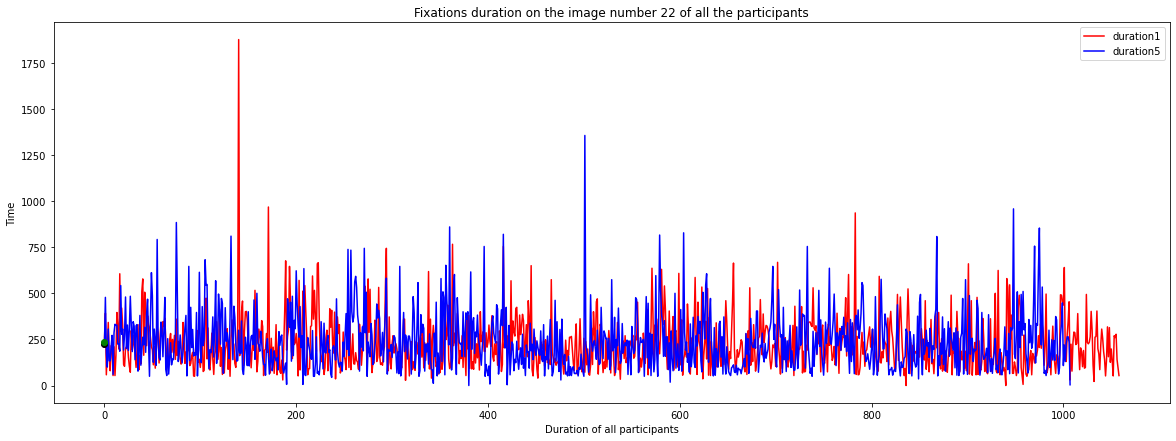

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=True, sharex=True)

plt.plot(duration1, color = 'red' , label = 'duration1')
plt.plot(duration5, color = 'blue' , label = 'duration5')
plt.title('Fixations duration on the image number 22 of all the participants')
plt.xlabel('Duration of all participants') 
plt.ylabel('Time')
plt.legend() # to include the legend in the file 
plt.plot(mean_duration1, marker='o', color='k')
plt.plot(mean_duration5, marker='o', color='g')
plt.show()


# Fixation Duration quartiles!
Quartiles are a statiscal index that provides information on the structure of the distribution of a quantitative statistical character (the duration in this case).
Once the data has been sorted, the quartiles are the three values that divide the set of data into four intervals of equal size.
* The first quartile (corresponding to the value 0.25) is defined as the lower quartile,
* The second quartile coincides with the median of the distribution. 
* The third (corresponding to the value 0.75) is called the quartile higher.

Quartiles, like deciles and percentiles, are part of the more general concept of subdivision of an ordered distribution into **q** equal parts called quantiles: they are therefore position indices that give an idea about the order of magnitude with which a quantitative variable manifests itself on a sample or population.

Let's calculate them, both at 1st and 5th iteration.

In [17]:
print("[1st iteration] DURATION QUARTILE:")
print(np.percentile(duration1, 25))  # Q1: 25% of fixations have a duration of 120ms
print(np.percentile(duration1, 50))  # median: 50% of fixation have a duration of 198 ms...
print(np.percentile(duration1, 75)) # Q3

print("[5th iteration] DURATION QUARTILE:")
print(np.percentile(duration5, 25))  # Q1
print(np.percentile(duration5, 50))  # median
print(np.percentile(duration5, 75)) # Q3

[1st iteration] DURATION QUARTILE:
122.0
198.0
287.0
[5th iteration] DURATION QUARTILE:
128.0
208.0
310.5


#  Fixation duration Boxplot!
A quick visual summary of the variability of duration: boxplots allow you to represent on the same graph five of the most used position measures in statistics.
They show the median, upper and lower quartiles, minimum and maximum values, and any outliers.

The height of the box is equal to the interquartile range (IQR) and contains the central 50% of the observations made, those between the first and third quartiles.
The line inside the box instead represents the median.
The two segments that start from the box and extend upwards and downwards are called "whiskers". Whiskers indicate the dispersion of values below the first quartile and above the third quartile not classified as outliers.
Isolated points indicate possible outliers.

Text(0.5, 1.0, 'Duration of fixations on image number 22 at 1st and 5th iteration')

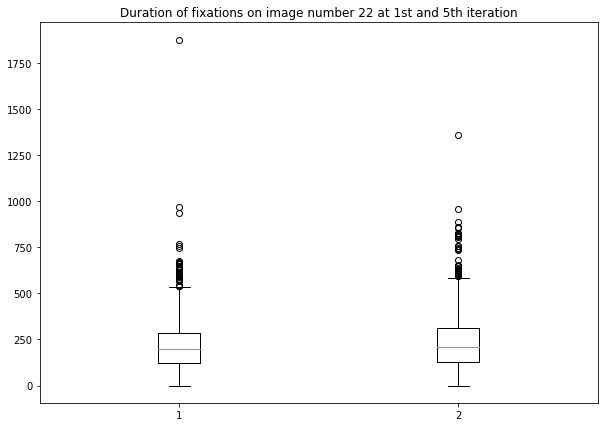

In [18]:
import seaborn as sns
 
#axs[0].set_yticks([0, 198, 500, 750, 100, 1250, 1750])
fig, ax = plt.subplots(figsize = (10,7))
duration = [duration1, duration5]
ax.boxplot(duration)
ax.set_title('Duration of fixations on image number 22 at 1st and 5th iteration')




We can see that there are many outliers in both boxplots.
We are going to understand if they are mostly related to a single/set of participants or to an image detail.

We can see that:
* for the first values of duration (duration1), the majority of outliers is between 500 and 700
* for the second values of duration (duration5), the majority of outliers is between 500 and 1000

So let' select, from the reduced datasets obtained before, the correspondent rows and let's see if these are related to the same subject index (same participant) or on a certain detail of the image (or maybe both).



Starting from the 1st iteration data

In [19]:
iteration1_img22 =iteration1[(iteration1['filenumber']==22)]
print(iteration1_img22)

          SUBJECTINDEX  category  eye  filenumber  iteration   pupil  sample  \
24                 1.0       7.0  1.0        22.0        1.0  1199.0    25.0   
25                 1.0       7.0  1.0        22.0        1.0  1199.0    26.0   
26                 1.0       7.0  1.0        22.0        1.0  1199.0    27.0   
27                 1.0       7.0  1.0        22.0        1.0  1200.0    28.0   
28                 1.0       7.0  1.0        22.0        1.0  1202.0    29.0   
...                ...       ...  ...         ...        ...     ...     ...   
32196726          45.0       7.0  1.0        22.0        1.0   552.0  3047.0   
32196727          45.0       7.0  1.0        22.0        1.0   553.0  3048.0   
32196728          45.0       7.0  1.0        22.0        1.0   553.0  3049.0   
32196729          45.0       7.0  1.0        22.0        1.0   553.0  3050.0   
32196730          45.0       7.0  1.0        22.0        1.0   552.0  3051.0   

          time  trial           x      

In [20]:
iteration1_img22_time500_700 =iteration1_img22[(iteration1_img22['time']>500) & (iteration1_img22['time']<700)]
print(iteration1_img22_time500_700)

          SUBJECTINDEX  category  eye  filenumber  iteration  pupil  sample  \
274                1.0       7.0  1.0        22.0        1.0  793.0   275.0   
275                1.0       7.0  1.0        22.0        1.0  793.0   276.0   
276                1.0       7.0  1.0        22.0        1.0  791.0   277.0   
277                1.0       7.0  1.0        22.0        1.0  790.0   278.0   
278                1.0       7.0  1.0        22.0        1.0  790.0   279.0   
...                ...       ...  ...         ...        ...    ...     ...   
32194076          45.0       7.0  1.0        22.0        1.0  433.0   397.0   
32194077          45.0       7.0  1.0        22.0        1.0  433.0   398.0   
32194078          45.0       7.0  1.0        22.0        1.0  433.0   399.0   
32194079          45.0       7.0  1.0        22.0        1.0  433.0   400.0   
32194080          45.0       7.0  1.0        22.0        1.0  433.0   401.0   

          time  trial           x           y  
274

Let's see in this ultra reduced dataset which participants we can found

In [21]:
iteration1_img22_time500_700.SUBJECTINDEX.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45.])

All the participants are involved! So it is clearly a detail of the image that draw their attention!
Let's try to understand coordinates...

In [22]:
iteration1_img22_time500_700 =iteration1_img22_time500_700[(iteration1_img22_time500_700['x']>342) & (iteration1_img22_time500_700['x']<700)]
print(iteration1_img22_time500_700)

          SUBJECTINDEX  category  eye  filenumber  iteration   pupil  sample  \
274                1.0       7.0  1.0        22.0        1.0   793.0   275.0   
275                1.0       7.0  1.0        22.0        1.0   793.0   276.0   
276                1.0       7.0  1.0        22.0        1.0   791.0   277.0   
869902             2.0       7.0  1.0        22.0        1.0  1117.0   302.0   
869903             2.0       7.0  1.0        22.0        1.0  1113.0   303.0   
...                ...       ...  ...         ...        ...     ...     ...   
32194016          45.0       7.0  1.0        22.0        1.0   445.0   337.0   
32194017          45.0       7.0  1.0        22.0        1.0   445.0   338.0   
32194018          45.0       7.0  1.0        22.0        1.0   443.0   339.0   
32194019          45.0       7.0  1.0        22.0        1.0   442.0   340.0   
32194020          45.0       7.0  1.0        22.0        1.0   442.0   341.0   

          time  trial           x      

On 4474 samples with time between 500 and 700ms, more than 3300 (75%) are concentrated in the area delimited by these x values: 342 and 700.

We will remember this point!

### Doing the same work on the 5th iteration data

In [23]:
iteration5_img22 =iteration5[(iteration5['filenumber']==22)]
print(iteration5_img22)

          SUBJECTINDEX  category  eye  filenumber  iteration  pupil  sample  \
692672             1.0       7.0  1.0        22.0        5.0  852.0    53.0   
692673             1.0       7.0  1.0        22.0        5.0  852.0    54.0   
692674             1.0       7.0  1.0        22.0        5.0  851.0    55.0   
692675             1.0       7.0  1.0        22.0        5.0  851.0    56.0   
692676             1.0       7.0  1.0        22.0        5.0  849.0    57.0   
...                ...       ...  ...         ...        ...    ...     ...   
32791685          45.0       7.0  1.0        22.0        5.0  206.0  3048.0   
32791686          45.0       7.0  1.0        22.0        5.0    0.0  3049.0   
32791687          45.0       7.0  1.0        22.0        5.0    0.0  3050.0   
32791688          45.0       7.0  1.0        22.0        5.0    0.0  3051.0   
32791689          45.0       7.0  1.0        22.0        5.0    0.0  3052.0   

          time  trial             x             y  

In [24]:
iteration5_img22_time500_1000 =iteration5_img22[(iteration5_img22['time']>500) & (iteration5_img22['time']<1000)]
print(iteration5_img22_time500_1000)

          SUBJECTINDEX  category  eye  filenumber  iteration  pupil  sample  \
692922             1.0       7.0  1.0        22.0        5.0  591.0   303.0   
692923             1.0       7.0  1.0        22.0        5.0  590.0   304.0   
692924             1.0       7.0  1.0        22.0        5.0  590.0   305.0   
692925             1.0       7.0  1.0        22.0        5.0  587.0   306.0   
692926             1.0       7.0  1.0        22.0        5.0  587.0   307.0   
...                ...       ...  ...         ...        ...    ...     ...   
32789186          45.0       7.0  1.0        22.0        5.0  418.0   549.0   
32789187          45.0       7.0  1.0        22.0        5.0  417.0   550.0   
32789188          45.0       7.0  1.0        22.0        5.0  417.0   551.0   
32789189          45.0       7.0  1.0        22.0        5.0  417.0   552.0   
32789190          45.0       7.0  1.0        22.0        5.0  417.0   553.0   

          time  trial           x           y  
692

Let's see in this ultra reduced dataset which participants we can found

In [25]:
iteration5_img22_time500_1000.SUBJECTINDEX.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45.])

All the participants are involved too! So also in this case is a detail of the image that draw their attention!
Let's try to understand coordinates...

In [26]:
iteration5_img22_time500_1000 =iteration5_img22_time500_1000[(iteration5_img22_time500_1000['x']>316) & (iteration5_img22_time500_1000['x']<850)]
print(iteration5_img22_time500_1000)

          SUBJECTINDEX  category  eye  filenumber  iteration  pupil  sample  \
692922             1.0       7.0  1.0        22.0        5.0  591.0   303.0   
692923             1.0       7.0  1.0        22.0        5.0  590.0   304.0   
692924             1.0       7.0  1.0        22.0        5.0  590.0   305.0   
692925             1.0       7.0  1.0        22.0        5.0  587.0   306.0   
692926             1.0       7.0  1.0        22.0        5.0  587.0   307.0   
...                ...       ...  ...         ...        ...    ...     ...   
32789186          45.0       7.0  1.0        22.0        5.0  418.0   549.0   
32789187          45.0       7.0  1.0        22.0        5.0  417.0   550.0   
32789188          45.0       7.0  1.0        22.0        5.0  417.0   551.0   
32789189          45.0       7.0  1.0        22.0        5.0  417.0   552.0   
32789190          45.0       7.0  1.0        22.0        5.0  417.0   553.0   

          time  trial           x           y  
692

On 11225 samples with time between 500 and 1000ms, more than 8600 (76%) are concentrated in the area delimited by these x values: 316 and 850.

We will remember this point!

# Now let's investigate on fixation positions!

As we said before, all_Efix lists store lists with some data for different fixations: starttime, endtime, duration, endx, endy.

We want the end positions of each fixation of each participant: so we need endx and endy, the last 2 elements of each list.

#### Start from endx (that is the position on the horizantal axis of the fixation)

Endx is the 4th (index 3) element of each list in the all_Efix list: so we are going to access to all_Efix1 and all_Efix5, to store endx of each fixation of each participant, both at 1st and 5th iteraiton.

We use 2 different arrays ("endx1" and "endx5") to store these data.

In [27]:
#Endx is the fourth (3) element of each list in the list
endx1 = []
endx5 = []


for i in range (0,len(all_Efix1)):
    for j in range (0, len(all_Efix1[i])):
        if(all_Efix1[i][j][3]!=100000000.0):
            endx1.append(all_Efix1[i][j][3])
    
for i in range (0,len(all_Efix5)):
    for j in range (0, len(all_Efix5[i])):
        if(all_Efix5[i][j][3]!=100000000.0):
            endx5.append(all_Efix5[i][j][3])
    
print(endx1)
print(endx5) 
    
    
#print(len(duration1))
#print(duration1)
mean_endx1= np.mean(endx1, axis = 0)
mean_endx5= np.mean(endx5, axis = 0)

print(mean_endx1, mean_endx5)

[640.0, 355.9, 330.2, 733.3, 677.4, 624.9, 269.6, 294.1, 255.0, 803.8, 829.4, 677.4, 663.9, 275.4, 688.0, 664.3, 270.6, 616.5, 679.3, 746.4, 228.1, 252.4, 286.2, 638.9, 384.9, 335.4, 762.6, 781.8, 876.2, 482.1, 217.3, 689.1, 712.1, 1044.9, 1069.6, 1092.7, 1047.1, 826.4, 841.7, 346.4, 285.8, 611.4, 627.1, 331.8, 125.8, 639.8, 410.0, 332.7, 392.5, 749.0, 810.9, 831.3, 274.6, 298.5, 448.6, 463.4, 353.5, 694.5, 714.1, 388.0, 308.6, 470.1, 351.4, 506.4, 433.8, 374.8, 707.1, 731.9, 642.4, 359.5, 489.8, 873.8, 985.8, 1019.4, 970.7, 1071.2, 660.0, 156.7, 237.7, 212.6, 1124.2, 1215.3, 1225.2, 1244.7, 1260.8, 1235.8, 1250.0, 1255.6, 1267.8, 590.7, 601.5, 575.1, 135.5, 187.3, 362.6, 641.2, 408.1, 371.6, 732.2, 708.2, 943.1, 918.4, 901.7, 876.3, 552.7, 527.3, 731.0, 1243.3, 1251.8, 1245.8, 285.9, 260.4, 246.0, 232.7, 208.7, 264.7, 104.2, 73.7, 402.9, 376.4, 348.5, 567.2, 642.7, 480.4, 464.5, 402.6, 379.1, 321.1, 387.5, 693.2, 669.9, 241.2, 215.6, 930.3, 1016.3, 991.7, 1257.4, 1231.8, 1247.8, 676.2

#### Go on with endy (that is the position on the vertical axis of the fixation)

Endy is the 5th (index 4) element of each list in the all_Efix list: so we are going to access to all_Efix1 and all_Efix5, to store endy of each fixation of each participant, both at 1st and 5th iteraiton.

We use 2 different arrays ("endy1" and "endy5") to store these data.

In [28]:
#Endy is the fifth (4) element of each list in the list
endy1 = []
endy5 = []

for i in range (0,len(all_Efix1)):
    for j in range (0, len(all_Efix1[i])):
        if(all_Efix1[i][j][4]!=100000000.0):
            endy1.append(all_Efix1[i][j][4])
    
for i in range (0,len(all_Efix5)):
    for j in range (0, len(all_Efix5[i])):
        if(all_Efix5[i][j][4]!=100000000.0):
            endy5.append(all_Efix5[i][j][4])
    
print(endy1)
print(endy5) 
    
    
#print(len(duration1))
#print(duration1)
mean_endy1= np.mean(endy1, axis = 0)
mean_endy5= np.mean(endy5, axis = 0)

print(mean_endy1, mean_endy5)

[482.0, 403.6, 398.4, 433.9, 764.8, 831.4, 358.1, 363.1, 348.3, 305.1, 302.1, 546.7, 568.1, 377.7, 526.9, 494.3, 370.9, 523.2, 506.2, 623.0, 328.4, 336.2, 359.8, 484.2, 438.4, 407.3, 267.3, 250.3, 186.4, 453.4, 640.7, 913.4, 902.8, 945.5, 939.6, 916.7, 868.7, 314.0, 293.7, 302.1, 368.8, 553.0, 532.5, 466.0, 757.1, 485.6, 417.5, 416.4, 358.8, 336.0, 187.6, 172.8, 392.0, 382.8, 373.9, 353.9, 356.5, 480.3, 464.6, 393.8, 379.6, 356.2, 367.1, 336.8, 309.8, 399.6, 617.6, 606.9, 478.3, 384.6, 394.4, 230.9, 354.3, 452.3, 719.8, 729.5, 825.2, 829.3, 810.2, 805.0, 545.4, 493.2, 468.3, 451.9, 287.7, 116.9, 83.6, 309.8, 364.2, 154.8, 131.5, 76.7, 68.0, 189.1, 341.0, 479.3, 448.1, 441.6, 725.2, 718.2, 419.0, 412.6, 216.4, 219.3, 393.2, 394.3, 480.8, 563.0, 491.6, 467.0, 789.3, 786.4, 729.3, 419.9, 411.7, 307.0, 184.7, 136.2, 348.9, 342.9, 375.1, 454.1, 479.6, 388.0, 366.3, 320.4, 310.0, 293.3, 394.4, 736.7, 749.7, 813.3, 815.9, 222.1, 479.3, 475.5, 477.6, 453.7, 474.3, 385.4, 361.8, 336.4, 479.1, 4

# Now we have end position both at 1st and 5th iteration! Let's graph them!

On the horizontal axis we have the x values, on the vertical one we have the y values.

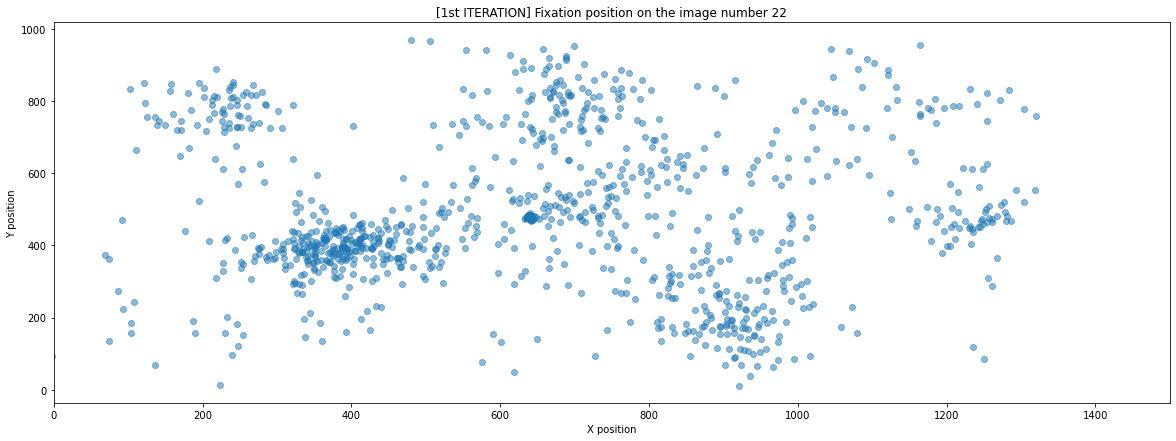

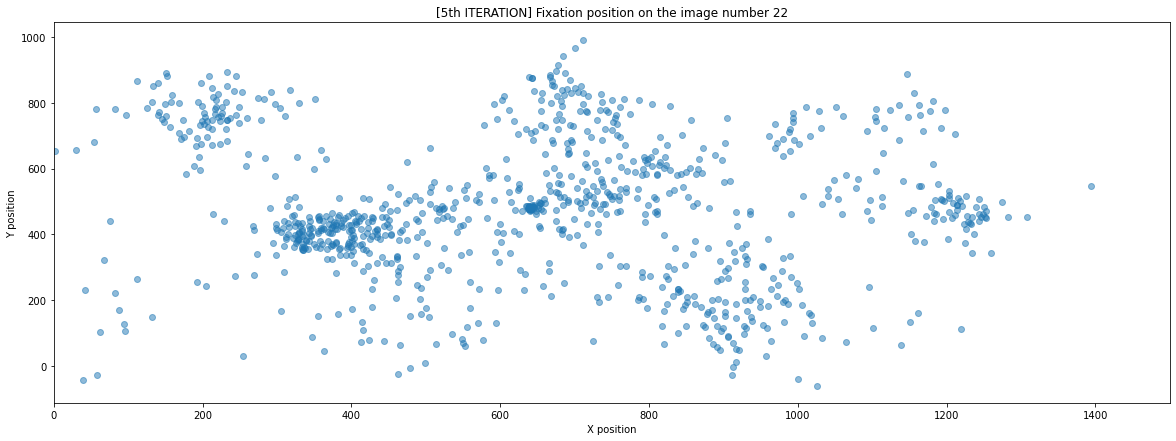

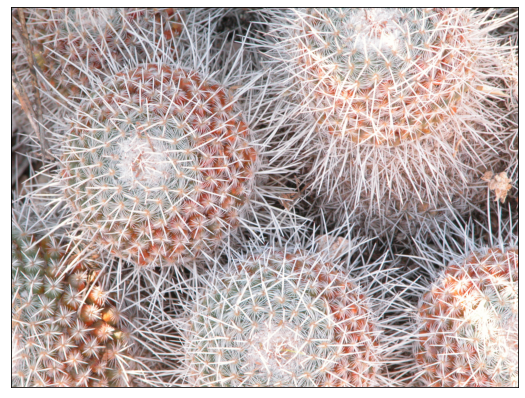

In [29]:

import matplotlib.image as mpimg

fig, axs = plt.subplots(1, 1 , figsize=(20, 7), sharey=True, sharex=False)
plt.scatter(endx1, endy1, alpha=0.5)
# plt.plot(endx1, endy1) 
plt.title('[1st ITERATION] Fixation position on the image number 22')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1500)
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=True, sharex=True)
plt.scatter(endx5, endy5, alpha=0.5)
plt.title('[5th ITERATION] Fixation position on the image number 22')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1500)
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=False, sharex=False)
img = mpimg.imread('7_22.png')
imgplot = plt.imshow(img)
plt.xticks([]) 
plt.yticks([]) 
plt.show()

# What did we understand?
We have seen how fixations duration change between the first and the fifth iteration.
We have seen how their positions change between them, and where fixations concentrate: we can see that there are some "rough" area of interest, probably because there is a detail in those position that capture the participant's gaze. 

We also have seen how duration values distribute themselves within the participants.

# So?
We can say that positions seem to identify some areas of interest in which fixations are concentrated: we will later identify better with clustering these areas.
The duration, however, does not provide us particular information.

# For completeness, let's do the same work on saccades.

So let's collect data of the image number 22. Before on the 1st iteration, with the technique explained before: 3 "all lists" of 45 lists.

In [30]:
all_xsac1 = [] #store lists of x position of each participant 
all_ysac1 = []
all_timesac1 = []

# all_xfix1 = np.array(all_xfix1)
# all_yfix1 = np.array(all_yfix1)
# all_timefix1 = np.array(all_timefix1)


for i in range (1,46):
    xsac1 = [(iteration1_img22[(iteration1_img22['SUBJECTINDEX']==i)]['x'])]#x positions of 1st iteration of image number 22
    ysac1 = [(iteration1_img22[(iteration1_img22['SUBJECTINDEX']==i)]['y'])]#x positions of 1st iteration of image number 22
    timesac1 = [(iteration1_img22[(iteration1_img22['SUBJECTINDEX']==i)]['time'])]#x positions of 1st iteration of image number 22
    
#    print(timefix1)

    all_xsac1.append(xsac1)   #store lists of x position of each participant 
    all_ysac1.append(ysac1)    
    all_timesac1.append(timesac1)   


#print(all_xfix1) 
# print(all_xfix1[44]) 


print(len(all_xsac1))
print(len(all_ysac1))
print(len(all_timesac1))


45
45
45


In [31]:
all_Ssac1 = []
all_Esac1 = []

for i in range (0,45):
    partial_Ssac1 , partial_Esac1 = saccade_detection(np.array(all_xsac1[i]), np.array(all_ysac1[i]), np.array(all_timesac1[i]), missing=0.0, minlen=5, maxvel=40, maxacc=340)
    all_Ssac1.append(partial_Ssac1)
    all_Esac1.append(partial_Esac1)
    
    
print(all_Ssac1) #list of 45 lists, each with n starttime of n-saccades of each participant 
print(len(all_Ssac1))

[[[4], [92], [192], [526], [572], [674], [926], [1142], [1168], [1238], [1394], [1406], [1448], [1710], [1718], [1754], [1902], [1938], [1988], [2166], [2274], [2320], [2470], [2862], [2882], [2912], [2968], [3044], [3154], [3268], [3276], [3314], [3344], [3368], [3414], [3710], [3868], [4078], [4092], [4140], [4186], [4504], [4558], [4594], [4784], [4812], [4824], [4838], [4920], [4928], [4982], [5040], [5050], [5066], [5206], [5282], [5294], [5312], [5356], [5406], [5450], [5720], [5746], [5856]], [[4], [50], [92], [112], [126], [270], [348], [372], [476], [504], [514], [590], [644], [760], [780], [944], [976], [1004], [1048], [1116], [1132], [1442], [1570], [1604], [1628], [1664], [1682], [1748], [1786], [1928], [2048], [2082], [2104], [2112], [2348], [2378], [2402], [2484], [2512], [2652], [2680], [2816], [2844], [2856], [2962], [2974], [2988], [3200], [3210], [3270], [3310], [3342], [3530], [3542], [3578], [3592], [3664], [3706], [3820], [3838], [3856], [3908], [3920], [4040], [40

In [32]:
# print(all_Esac1) #list of 45 lists, each with n [starttime, endtime, duration, startx, starty, endx, endy] of n-saccades of each participant

# print(len(all_Esac1)) # 45


Now on the 5th iteration

In [33]:
all_xsac5 = [] #store 45 lists of x position of each participant 
all_ysac5 = []
all_timesac5 = []

for i in range (1,46):
    xsac5 = [(iteration5_img22[(iteration5_img22['SUBJECTINDEX']==i)]['x'])]#x positions of 5th iteration of image number 22
    ysac5 = [(iteration5_img22[(iteration5_img22['SUBJECTINDEX']==i)]['y'])]#x positions of 5th iteration of image number 22
    timesac5= [(iteration5_img22[(iteration5_img22['SUBJECTINDEX']==i)]['time'])]#x positions of 5th iteration of image number 22
    
#    print(timefix1)

    all_xsac5.append(xsac5)   #store lists of x position of each participant 
    all_ysac5.append(ysac5)    
    all_timesac5.append(timesac5)   


#print(all_xfix1) 
# print(all_xfix1[44]) 


print(len(all_xsac5))
print(len(all_ysac5))
print(len(all_timesac5))


45
45
45


In [34]:
all_Ssac5 = []
all_Esac5 = []

for i in range (0,45):
    partial_Ssac5 , partial_Esac5 = saccade_detection(np.array(all_xsac5[i]), np.array(all_ysac5[i]), np.array(all_timesac5[i]), missing=0.0, minlen=5, maxvel=40, maxacc=340)
    all_Ssac5.append(partial_Ssac5)
    all_Esac5.append(partial_Esac5)
    
    
print(all_Ssac5) #list of 45 lists, each with n starttime of n-saccades of each participant 
print(len(all_Ssac5))

[[[4], [20], [104], [206], [312], [340], [376], [456], [476], [512], [532], [560], [616], [628], [698], [708], [780], [794], [852], [874], [894], [910], [918], [930], [962], [1004], [1206], [1226], [1244], [1264], [1576], [1754], [1826], [1978], [2156], [2348], [2414], [2458], [2476], [2674], [2686], [2718], [2734], [2742], [2780], [2800], [2824], [2838], [3022], [3068], [3216], [3334], [3370], [3510], [3710], [3750], [3766], [3986], [4022], [4038], [4292], [4312], [4348], [4378], [4402], [4456], [4530], [4540], [4554], [4606], [4622], [4656], [4684], [4696], [4766], [4904], [5008], [5028], [5064], [5078], [5216], [5294], [5368], [5388], [5488], [5504], [5556], [5620], [5684], [5736], [5912], [5928], [5986]], [[3], [37], [113], [409], [429], [443], [597], [629], [671], [685], [761], [799], [821], [833], [977], [1191], [1237], [1251], [1397], [1413], [1439], [1529], [1561], [1733], [1797], [1813], [1825], [1853], [1901], [1913], [2055], [2113], [2197], [2267], [2617], [2645], [2681], [2

In [35]:
# print(len(all_Ssac5)) #list of 45 lists, each with n starttime of n-saccade of each participant 
# print(len(all_Esac5))  #list of 45 lists, each with n [starttime, endtime, duration, startx, starty, endx, endy] of n-saccades of each participant


# print(all_Ssac5) # [starttime]
# print(all_Esac5) # [starttime, endtime, duration, startx, starty, endx, endy]


In [36]:
# print(all_Esac1)
# print("---------------------------------------------")
# print(all_Esac5)

We have data about saccades of the image number 22 both in the 1st and in 5th iteration.

# Let's investigate on saccades duration

all_Esac lists store lists with some data for different saccades: starttime, endtime, duration, startx, starty, endx, endy.

Duration is the third (index 2) element of each list in the all_Esac list: so we are going to access to all_Esac1 and all_Esac5, to store duration of each saccade of each participant, both at 1st and 5th iteraiton.

We use 2 different arrays ("sac duration1" and "sac duration5") to store these data.

In [37]:
#Duration is the third (2) element of each list in the list
sac_duration1 = []
sac_duration5 = []

for i in range (0,len(all_Esac1)):
    for j in range (0, len(all_Esac1[i])):
        sac_duration1.append(all_Esac1[i][j][2])
    
for i in range (0,len(all_Esac5)):
    for j in range (0, len(all_Esac5[i])):
        sac_duration5.append(all_Esac5[i][j][2])
    
    
    
print(len(sac_duration1))
print(sac_duration1) #durations of all saccades of each participant on image 22

print(len(sac_duration5))
print(sac_duration5)
sac_mean_duration1= np.mean(duration1, axis = 0)
sac_mean_duration5= np.mean(duration5, axis = 0)

# print(mean_duration1, mean_duration5)

4196
[86, 98, 332, 44, 98, 250, 214, 24, 68, 154, 6, 38, 260, 6, 34, 144, 34, 48, 174, 106, 44, 102, 390, 18, 28, 54, 74, 108, 112, 6, 36, 28, 22, 44, 294, 156, 208, 12, 46, 44, 316, 52, 34, 188, 26, 10, 12, 80, 6, 46, 56, 8, 14, 138, 74, 10, 16, 42, 48, 42, 268, 24, 108, 44, 40, 18, 12, 142, 76, 22, 102, 26, 8, 74, 52, 114, 18, 162, 30, 26, 42, 66, 14, 308, 126, 28, 22, 34, 16, 64, 36, 140, 118, 32, 20, 6, 234, 28, 22, 80, 26, 138, 26, 134, 26, 10, 104, 10, 12, 210, 8, 58, 38, 30, 186, 10, 34, 12, 70, 40, 112, 16, 16, 50, 10, 118, 54, 94, 14, 18, 68, 206, 6, 104, 234, 30, 42, 20, 12, 18, 16, 104, 100, 274, 12, 146, 64, 124, 30, 96, 22, 46, 86, 20, 16, 20, 20, 6, 64, 14, 128, 108, 70, 88, 44, 30, 24, 6, 12, 40, 46, 176, 10, 14, 122, 40, 178, 152, 66, 28, 54, 24, 64, 10, 100, 12, 126, 68, 36, 272, 10, 94, 46, 28, 8, 20, 32, 80, 36, 8, 6, 52, 72, 166, 84, 6, 36, 32, 18, 28, 14, 166, 32, 14, 130, 34, 34, 12, 110, 86, 38, 26, 6, 124, 50, 134, 10, 102, 104, 38, 46, 28, 26, 42, 74, 34, 52, 3

Now we have duration of all saccades of all participant at 1st and 5th iteration: let's try to graph these data to see if there are important differences between the 2 iterations.

On the horizontal axis we have all the saccades of all the participants
On the vertical axis we have time

We use red color for duration of 1st iteration's saccades, blue for the 5th one.

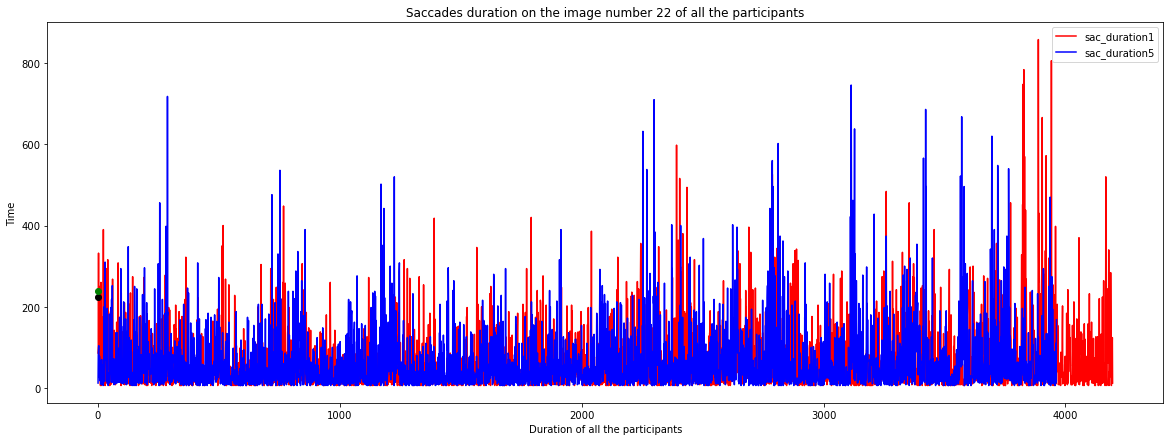

In [38]:

fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=True, sharex=True)

plt.plot(sac_duration1, color = 'red' , label = 'sac_duration1')
plt.plot(sac_duration5, color = 'blue' , label = 'sac_duration5')
plt.title('Saccades duration on the image number 22 of all the participants')
plt.xlabel('Duration of all the participants') 
plt.ylabel('Time')
plt.legend() # to include the legend in the file 
plt.plot(sac_mean_duration1, marker='o', color='k')
plt.plot(sac_mean_duration5, marker='o', color='g')
plt.show()


# The same work on saccades start and end-position

As we said before, all_Esac lists store lists with some data for different fixations: starttime, endtime, duration, startx, starty, endx, endy.

We want start positions and end positions of each saccade of each participant: so we need startx and starty, and endx and endy.

In [39]:
#Startx is the fourth (3) element of each list in the list
sac_startx1 = []
sac_startx5 = []

for i in range (0,len(all_Esac1)):
    for j in range (0, len(all_Esac1[i])):
        if(all_Esac1[i][j][3]!=100000000.0):
            sac_startx1.append(all_Esac1[i][j][3])
    
for i in range (0,len(all_Esac5)):
    for j in range (0, len(all_Esac5[i])):
        if(all_Esac5[i][j][3]!=100000000.0):
            sac_startx5.append(all_Esac5[i][j][3])
    

sac_mean_startx1= np.mean(sac_startx1, axis = 0)
sac_mean_startx5= np.mean(sac_startx5, axis = 0)

print(sac_mean_startx1, sac_mean_startx5)

618.5404 634.9266


In [40]:
#Starty is the fifth (4) element of each list in the list
sac_starty1 = []
sac_starty5 = []

for i in range (0,len(all_Esac1)):
    for j in range (0, len(all_Esac1[i])):
        if(all_Esac1[i][j][4]!=100000000.0):
            sac_starty1.append(all_Esac1[i][j][4])
    
for i in range (0,len(all_Esac5)):
    for j in range (0, len(all_Esac5[i])):
        if(all_Esac5[i][j][4]!=100000000.0):
            sac_starty5.append(all_Esac5[i][j][4])
    
#print(endx1)
#print(endx5) 
    
    
#print(len(duration1))
#print(duration1)
sac_mean_starty1= np.mean(sac_starty1, axis = 0)
sac_mean_starty5= np.mean(sac_starty5, axis = 0)

print(sac_mean_starty1, sac_mean_starty5)

472.5328 488.51538


On the horizontal axis we have the x values, on the vertical one we have the y values.

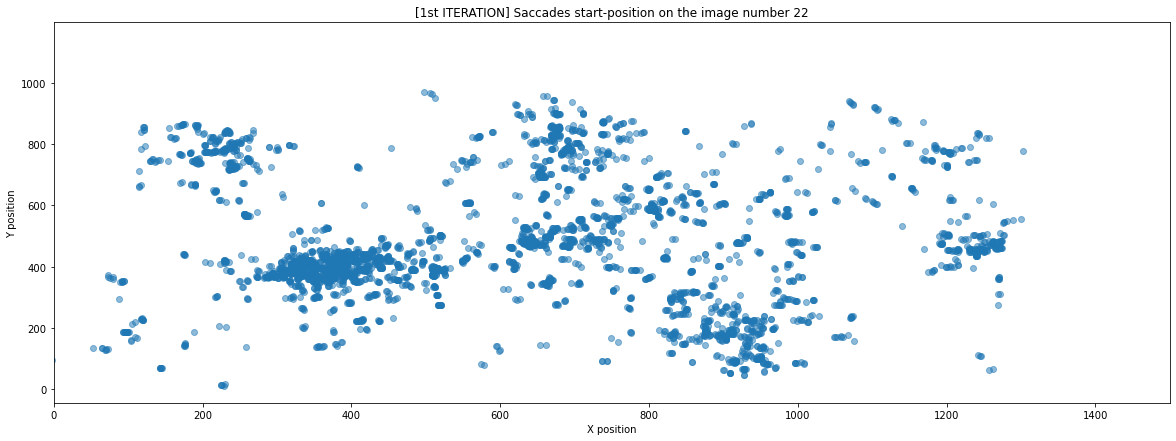

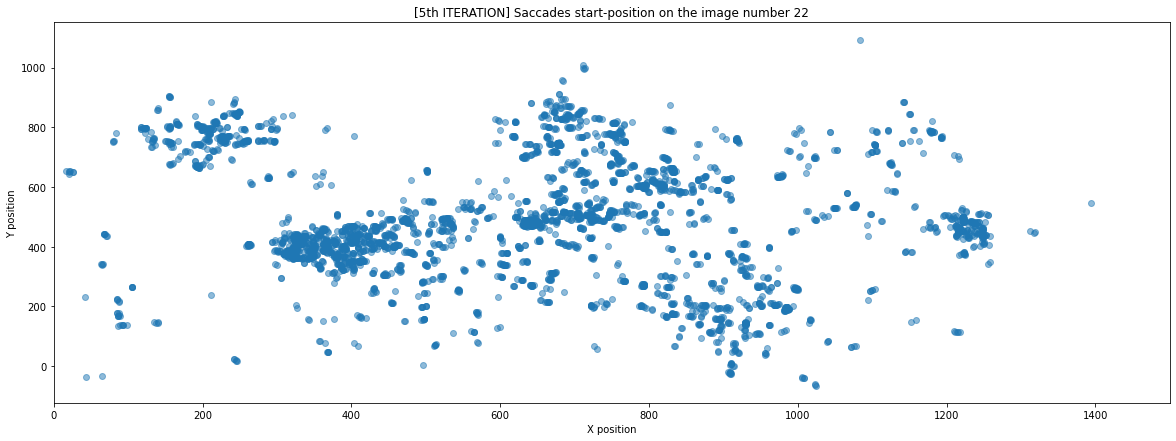

In [41]:
fig, axs = plt.subplots(1, 1 , figsize=(20, 7), sharey=True, sharex=False)
# plt.plot(sac_startx1, sac_starty1) 
plt.scatter(sac_startx1, sac_starty1, alpha=0.5)
plt.title('[1st ITERATION] Saccades start-position on the image number 22')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1500)
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=True, sharex=True)
# plt.plot(sac_startx5, sac_starty5) 
plt.scatter(sac_startx5, sac_starty5, alpha=0.5)
plt.title('[5th ITERATION] Saccades start-position on the image number 22')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1500)
plt.show()


## Go on with end positions.

In [42]:
#Endx is the sixth (5) element of each list in the list
sac_endx1 = []
sac_endx5 = []

for i in range (0,len(all_Esac1)):
    for j in range (0, len(all_Esac1[i])):
        if(all_Esac1[i][j][5]!=100000000.0):
            sac_endx1.append(all_Esac1[i][j][5])
    
for i in range (0,len(all_Esac5)):
    for j in range (0, len(all_Esac5[i])):
        if(all_Esac5[i][j][5]!=100000000.0):
            sac_endx5.append(all_Esac5[i][j][5])
    
sac_mean_endx1= np.mean(sac_endx1, axis = 0)
sac_mean_endx5= np.mean(sac_endx5, axis = 0)

print(sac_mean_endx1, sac_mean_endx5)

618.0472 634.93884


In [43]:
#Endy is the seventh (6) element of each list in the list
sac_endy1 = []
sac_endy5 = []

for i in range (0,len(all_Esac1)):
    for j in range (0, len(all_Esac1[i])):
        if(all_Esac1[i][j][6]!=100000000.0):
            sac_endy1.append(all_Esac1[i][j][6])
    
for i in range (0,len(all_Esac5)):
    for j in range (0, len(all_Esac5[i])):
        if(all_Esac5[i][j][6]!=100000000.0):
            sac_endy5.append(all_Esac5[i][j][6])
    

sac_mean_endy1= np.mean(sac_endy1, axis = 0)
sac_mean_endy5= np.mean(sac_endy5, axis = 0)

print(sac_mean_endy1, sac_mean_endy5)

472.6045 488.2509


On the horizontal axis we have the x values, on the vertical one we have the y values.

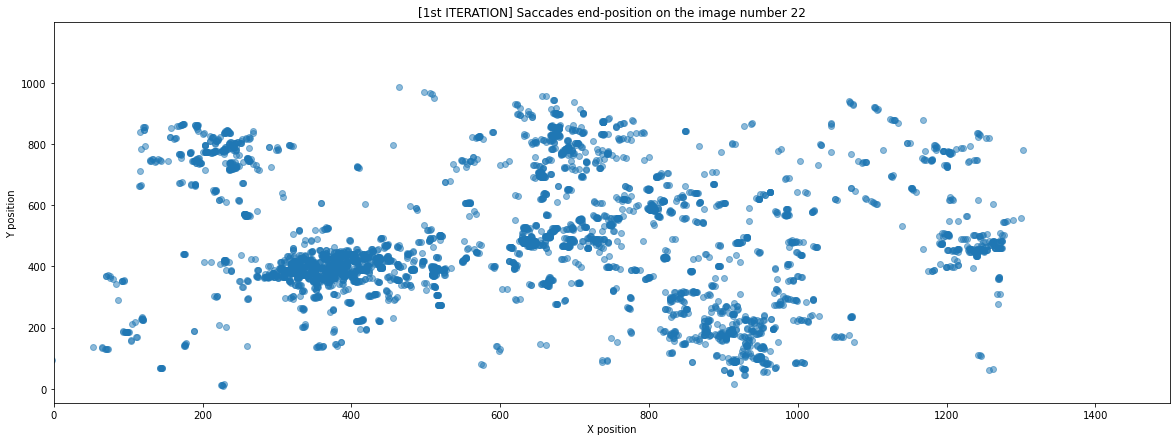

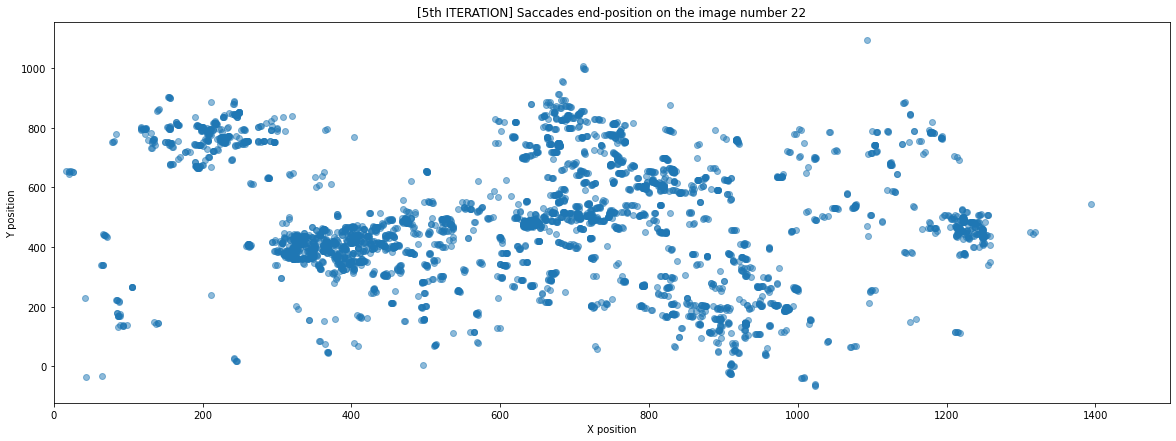

In [55]:
fig, axs = plt.subplots(1, 1 , figsize=(20, 7), sharey=True, sharex=False)
# plt.plot(sac_endx1, sac_endy1) 
plt.scatter(sac_endx1, sac_endy1, alpha=0.5)
plt.title('[1st ITERATION] Saccades end-position on the image number 22')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1500)
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=True, sharex=True)
# plt.plot(sac_endx5, sac_endy5) 
plt.scatter(sac_endx5, sac_endy5, alpha=0.5)

plt.title('[5th ITERATION] Saccades end-position on the image number 22')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1500)
plt.show()


# --------------------------------------------------------------------------------------------------------------1st RECAP #

We have collected until now data about duration and position of fixations and saccades of all the participants on the image number 22 during the 1st and the 5th iteration.

We can see that the functions that describe the duration trend tends to overlap sometimes. So, we don't have drastical changes in the fixation duration parameter. 
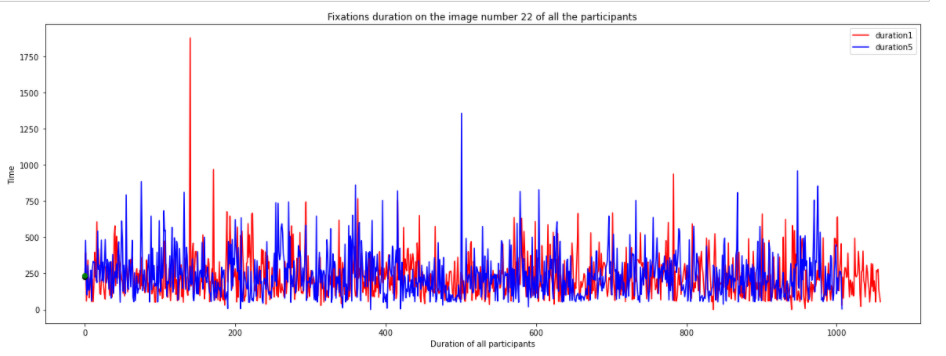
Then we also have graphically represented the distribution of the duration through simple dispersion and position indices, thanks to the bloxpots.
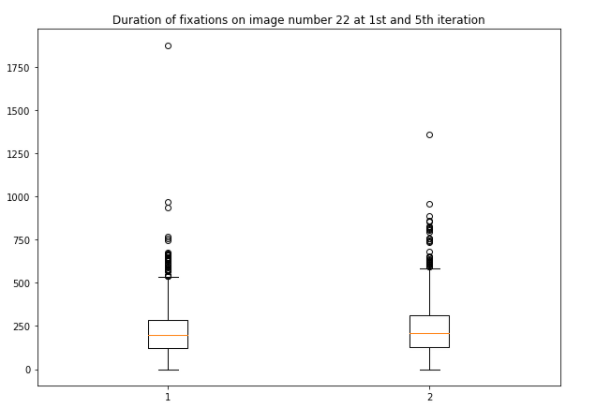
Also in this case, nothing of really interesting... so we passed to the fixations' position.

We have seen that they describe where the human gaze focuses on. 
In the graph, we can identify a *rough* area of interest in which fixations are concentrated, both in the 1st and in the 5th iteration.
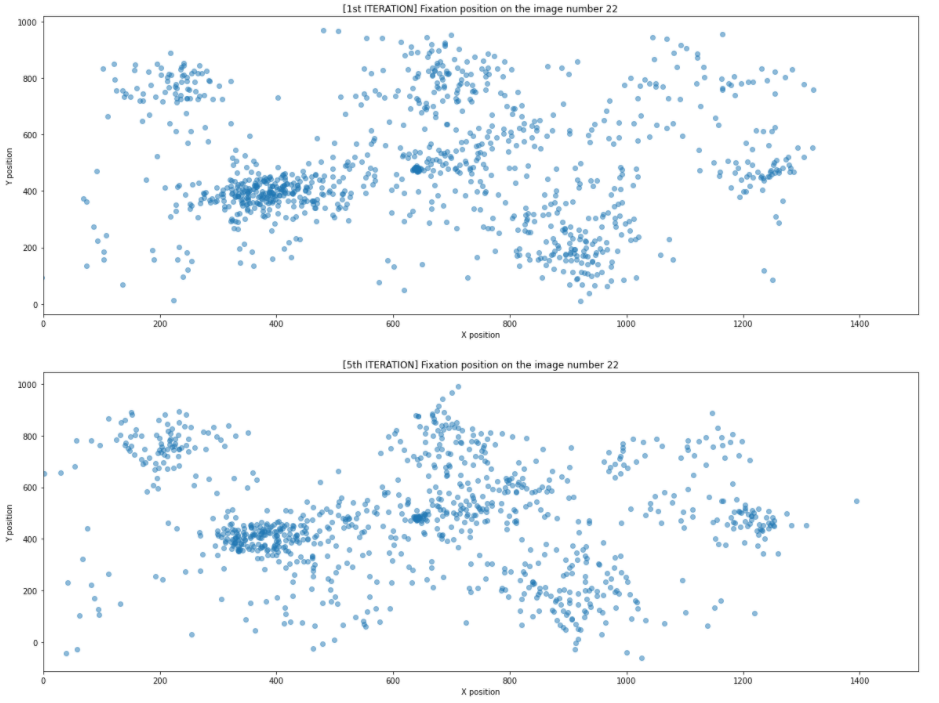

At this point, we have done a similar work related on the saccades:
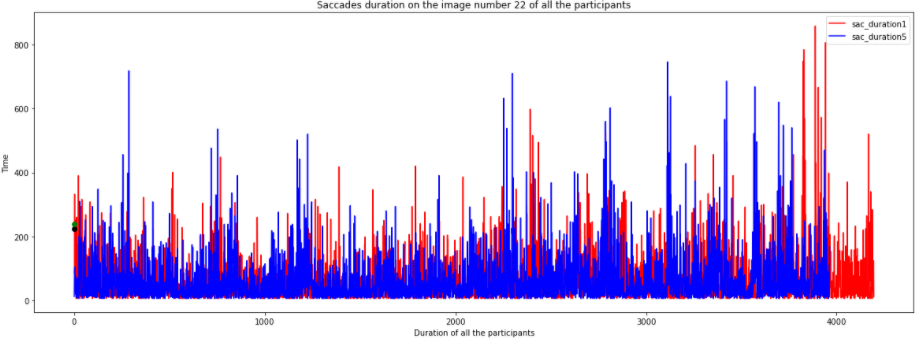
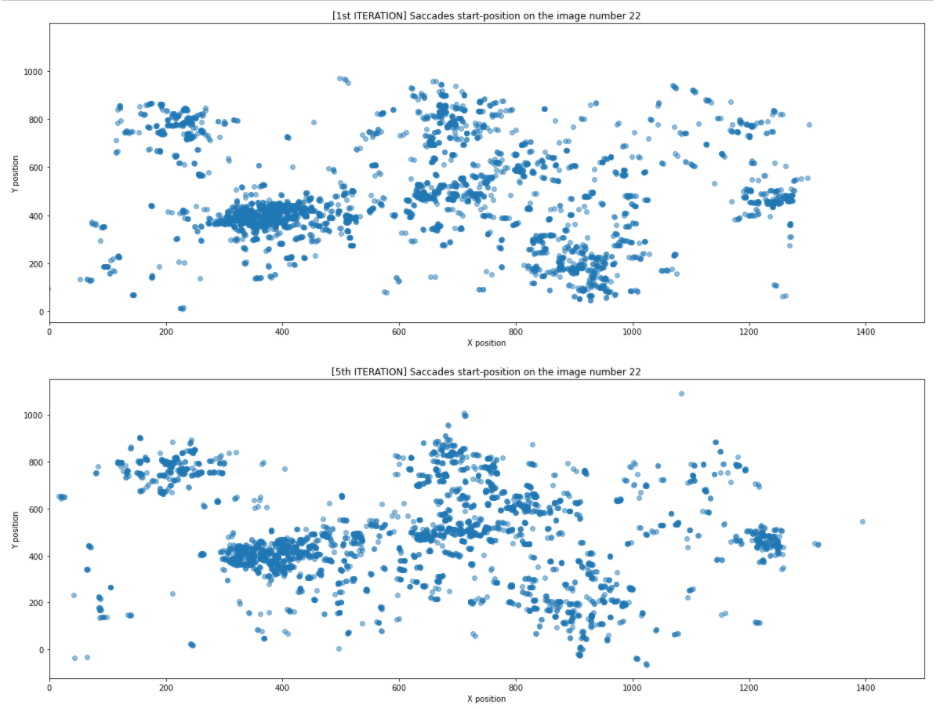
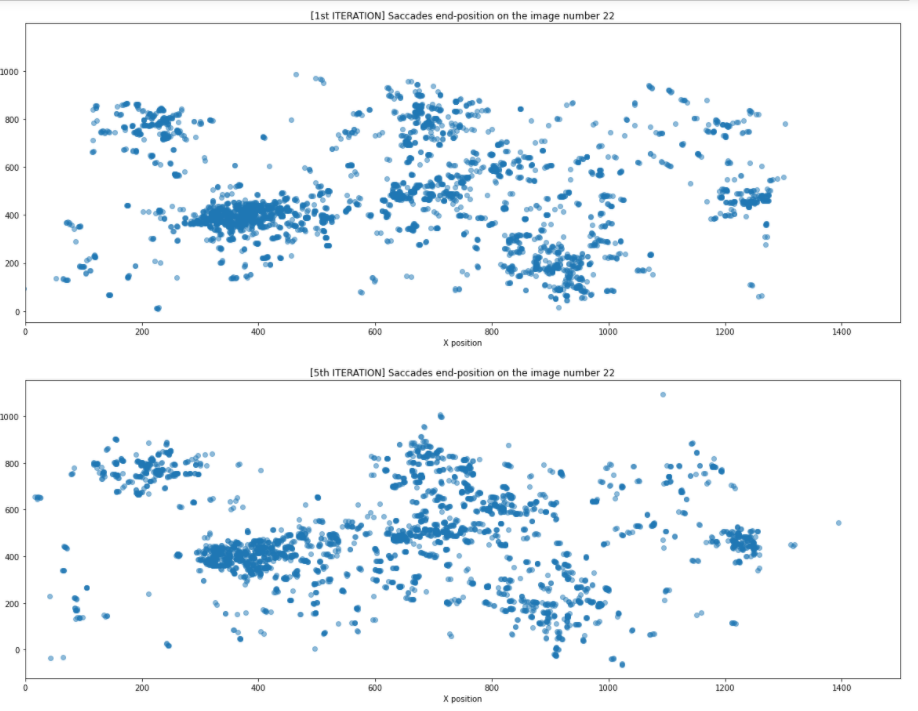

As we thought, durations are faster because saccades are just movements of the eye (while fixation is the stabilitation of the gaze on a certain point).
And also in this case, the most meaningful parameter are positions: start and end-positions are concentrated in some particular areas of the image.

# And now?
Our idea is to repeat just the fixations' position analysis on another image: we will have another graph that roughly identifies areas in which fixations are concentrated.

After doing this, we will perform *clustering* on fixations' position and we will compare results of this first and rough analysis with clustering results: in our opinion, rough areas will have a significant match on the most accurate clustering results.

Let's start selecting the data of 1st and 5th iteration on another image: number 29/category 11 [UNCLEAR IMAGES]

In [45]:
iteration1_img29 =iteration1[(iteration1['filenumber']==29)]
iteration5_img29 =iteration5[(iteration5['filenumber']==29)]



Select x, y and time data from this reduced dataset: the technique is the same. 3 "all lists" of 45 lists.

In [46]:
all_xfix1 = [] #store lists of x position of each participant 
all_yfix1 = []
all_timefix1 = []

# all_xfix1 = np.array(all_xfix1)
# all_yfix1 = np.array(all_yfix1)
# all_timefix1 = np.array(all_timefix1)


for i in range (1,46):
    xfix1 = [(iteration1_img29[(iteration1_img29['SUBJECTINDEX']==i)]['x'])]#x positions of 1st iteration of image number 22
    yfix1 = [(iteration1_img29[(iteration1_img29['SUBJECTINDEX']==i)]['y'])]#x positions of 1st iteration of image number 22
    timefix1 = [(iteration1_img29[(iteration1_img29['SUBJECTINDEX']==i)]['time'])]#x positions of 1st iteration of image number 22
    
#    print(timefix1)

    all_xfix1.append(xfix1)   #store lists of x position of each participant 
    all_yfix1.append(yfix1)    
    all_timefix1.append(timefix1)   


#print(all_xfix1) 
print(all_xfix1[44]) 


print(len(all_xfix1))
print(len(all_yfix1))
print(len(all_timefix1))


[32169321    640.500000
32169322    640.799988
32169323    641.200012
32169324    641.500000
32169325    641.500000
               ...    
32254694    792.700012
32254695    792.799988
32254696    792.500000
32254697    792.799988
32254698    793.200012
Name: x, Length: 8998, dtype: float32]
45
45
45


In [47]:
all_Sfix1 = []
all_Efix1 = []

for i in range (0,45):
    partial_Sfix1, partial_Efix1 = fixation_detection(np.array(all_xfix1[i]), np.array(all_yfix1[i]), np.array(all_timefix1[i]), missing=0.0, maxdist=25, mindur=50)
    all_Sfix1.append(partial_Sfix1)
    all_Efix1.append(partial_Efix1)
    
    
print(all_Sfix1) #list of 45 lists, each with n starttime of n-fixations of each participant 
print(len(all_Sfix1))

[[[167], [433], [683], [1107], [1435], [1789], [2031], [2371], [2451], [2881], [3135], [3191], [3521], [3605], [3861], [4171], [4485], [4817], [5137], [5369], [5477], [5835], [4], [284], [592], [854], [1054], [1432], [1686], [2074], [2286], [2610], [2682], [2896], [3132], [3214], [3374], [3672], [4014], [4370], [4590], [4680], [4862], [5044], [5332], [5524], [5778], [4], [272], [616], [946], [1196], [1390], [1782], [1944], [2312], [2420], [2552], [2838], [3098], [3444], [3646], [4000], [4390], [4702], [4992], [5186], [5284], [5364], [5586], [5768]], [[3], [399], [521], [633], [941], [1085], [1175], [1443], [1751], [2093], [2161], [2325], [2599], [3051], [3387], [3615], [3845], [3959], [4395], [4701], [4915], [5207], [5749], [3], [257], [445], [795], [925], [1051], [1221], [1331], [1411], [1603], [1857], [1931], [2039], [2321], [2549], [2697], [2859], [3087], [3187], [3351], [3453], [3687], [3811], [4099], [4279], [4509], [4643], [4743], [4909], [5017], [5225], [5481], [5901], [4], [278

In [48]:
# # print(all_Efix1) #list of 45 lists, each with n [starttime, endtime, duration, endx, endy] of n-fixations of each participant
# print(len(all_Efix1)) #45 entries (participants)
# print(len(all_Efix1[0])) #(0-44): number of fixations for the 0-participant: inside we have the lists of 5 element
# print(len(all_Efix1[1])) #(0-44): number of fixations for the 1-participant: inside we have the lists of 5 element
# print((all_Efix1[2][0])) # Lista di 5 entries coi dati relativi alla prima fissazione del 2 partecipante
# print(len(all_Efix1[1][0])) #=5

In [49]:
all_xfix5 = [] #store lists of x position of each participant 
all_yfix5 = []
all_timefix5 = []



for i in range (1,46):
    xfix5 = [(iteration5_img29[(iteration5_img29['SUBJECTINDEX']==i)]['x'])]#x positions of 5th iteration of image number 22
    yfix5 = [(iteration5_img29[(iteration5_img29['SUBJECTINDEX']==i)]['y'])]#x positions of 5th iteration of image number 22
    timefix5 = [(iteration5_img29[(iteration5_img29['SUBJECTINDEX']==i)]['time'])]#x positions of 5th iteration of image number 22
    
#    print(timefix1)

    all_xfix5.append(xfix5)   #store lists of x position of each participant 
    all_yfix5.append(yfix5)    
    all_timefix5.append(timefix5)   


#print(all_xfix1) 
print(all_xfix5) 


print(len(all_xfix5))
print(len(all_yfix5))
print(len(all_timefix5))


[[588925    640.299988
588926    640.299988
588927    640.400024
588928    640.299988
588929    640.299988
             ...    
625486    938.599976
625487    938.299988
625488    937.900024
625489    938.000000
625490    938.099976
Name: x, Length: 8999, dtype: float32], [1391356    638.099976
1391357    638.000000
1391358    638.000000
1391359    638.099976
1391360    637.900024
              ...    
1421816    756.099976
1421817    756.099976
1421818    756.000000
1421819    756.099976
1421820    756.200012
Name: x, Length: 8998, dtype: float32], [2135024    639.500000
2135025    639.700012
2135026    639.900024
2135027    639.700012
2135028    640.000000
              ...    
2186841    512.900024
2186842    512.400024
2186843    512.400024
2186844    512.299988
2186845    512.599976
Name: x, Length: 8997, dtype: float32], [2806281    642.700012
2806282    642.500000
2806283    642.400024
2806284    642.200012
2806285    642.200012
              ...    
2906919    631.200012
290692

In [50]:
all_Sfix5 = []
all_Efix5 = []

for i in range (0,45):
    partial_Sfix5, partial_Efix5 = fixation_detection(np.array(all_xfix5[i]), np.array(all_yfix5[i]), np.array(all_timefix5[i]), missing=0.0, maxdist=25, mindur=50)
    all_Sfix5.append(partial_Sfix5)
    all_Efix5.append(partial_Efix5)
    
    
print(all_Sfix5) #list of 45 lists, each with n starttime of n-fixations of each participant 
print(len(all_Sfix5))

[[[3], [225], [525], [729], [1179], [1527], [1625], [1787], [2095], [2205], [2393], [2493], [2723], [2977], [3061], [3235], [3855], [4085], [4315], [4515], [4829], [5059], [5491], [5723], [3], [381], [637], [1013], [1255], [1319], [1537], [1683], [1783], [1845], [2055], [2377], [2601], [2779], [2893], [3287], [3343], [3545], [3845], [4255], [4549], [5017], [5079], [5315], [5737], [4], [308], [518], [834], [1214], [1396], [1604], [1888], [2338], [2434], [2728], [2902], [3390], [3684], [4014], [4282], [4412], [4514], [4712], [4824], [4950], [5158], [5488], [5638], [5776]], [[4], [274], [610], [820], [1126], [1488], [1832], [2170], [2360], [2464], [2902], [3048], [3240], [3438], [3924], [4274], [4424], [4528], [4624], [4912], [5232], [5710], [3], [399], [731], [1215], [1365], [1729], [2309], [2517], [3231], [4603], [4889], [5811], [3], [1201], [1363], [1457], [1571], [1791], [2139], [2485], [2645], [2943], [3557], [4221], [5127], [5531], [5861]], [[3], [461], [747], [1155], [1471], [1761]

In [51]:
# # print(all_Efix1)#list of 45 lists, each with n [starttime, endtime, duration, endx, endy] of n-fixations of each participant
# print(len(all_Efix5)) #45 entries (participants)
# print(len(all_Efix5[0])) #(0-44):number of fixations for the 0-participant: inside have the lists of 5 element
# print(len(all_Efix5[1])) 
# print(len(all_Efix5[2][0])) # Lista di 5 entries coi dati relativi alla prima fissazione del 2 partecipant

As we said before, all_Efix lists store lists with some data for different fixations: starttime, endtime, duration, endx, endy.

We want end positions, both at 1st and 5th iteration.

In [52]:
#Endx is the fourth (3) element of each list in the list
endx1 = []
endx5 = []


for i in range (0,len(all_Efix1)):
    for j in range (0, len(all_Efix1[i])):
        if(all_Efix1[i][j][3]!=100000000.0):
            endx1.append(all_Efix1[i][j][3])
    
for i in range (0,len(all_Efix5)):
    for j in range (0, len(all_Efix5[i])):
        if(all_Efix5[i][j][3]!=100000000.0):
            endx5.append(all_Efix5[i][j][3])
    
print(endx1)
print(endx5) 
    
    
#print(len(duration1))
#print(duration1)
mean_endx1= np.mean(endx1, axis = 0)
mean_endx5= np.mean(endx5, axis = 0)

print(mean_endx1, mean_endx5)

[585.2, 532.0, 229.4, 173.8, 656.6, 786.0, 517.8, 475.4, 492.8, 545.6, 684.8, 710.3, 696.2, 715.3, 1148.5, 1201.5, 462.3, 220.3, 175.2, 405.8, 430.4, 270.5, 640.5, 500.8, 278.9, 232.7, 545.1, 826.3, 811.3, 754.4, 568.4, 1072.6, 1096.8, 1183.8, 1139.0, 1163.6, 963.8, 891.7, 1185.8, 1026.4, 473.9, 497.6, 206.4, 95.6, 70.3, 274.0, 570.1, 641.8, 377.6, 337.8, 351.1, 416.2, 330.7, 745.0, 756.8, 782.6, 807.9, 626.7, 514.4, 339.7, 311.0, 142.6, 193.8, 162.2, 298.0, 529.6, 776.7, 801.4, 897.4, 708.7, 423.8, 641.8, 698.9, 712.7, 736.1, 872.1, 876.8, 908.2, 817.5, 747.8, 745.4, 818.8, 708.8, 840.4, 446.5, 762.4, 972.9, 865.5, 867.4, 359.9, 685.9, 1038.1, 247.2, 178.8, 639.9, 635.0, 325.5, 666.5, 690.1, 347.8, 327.5, 241.6, 32.7, 49.3, 806.2, 817.4, 895.5, 680.1, 348.5, 431.3, 724.5, 729.1, 320.2, 1129.2, 1259.3, 1071.5, 637.2, 363.6, 295.2, 281.6, 368.0, 392.9, 154.4, 173.1, 98.8, 509.0, 697.8, 637.6, 765.2, 572.1, 493.1, 465.7, -1.1, 22.6, -30.3, 719.6, 741.1, 868.4, 678.0, 800.3, 824.1, 582.9,

In [53]:
#Endy is the fifth (4) element of each list in the list
endy1 = []
endy5 = []

for i in range (0,len(all_Efix1)):
    for j in range (0, len(all_Efix1[i])):
        if(all_Efix1[i][j][4]!=100000000.0):
            endy1.append(all_Efix1[i][j][4])
    
for i in range (0,len(all_Efix5)):
    for j in range (0, len(all_Efix5[i])):
        if(all_Efix5[i][j][4]!=100000000.0):
            endy5.append(all_Efix5[i][j][4])
    
print(endy1)
print(endy5) 
    
    
#print(len(duration1))
#print(duration1)
mean_endy1= np.mean(endy1, axis = 0)
mean_endy5= np.mean(endy5, axis = 0)

print(mean_endy1, mean_endy5)

[416.1, 544.9, 326.7, 375.8, 460.1, 399.5, 439.5, 531.6, 549.7, 599.4, 837.2, 841.8, 713.2, 696.3, 669.9, 724.9, 690.7, 773.2, 766.3, 194.4, 188.0, 79.9, 479.7, 337.7, 417.4, 474.2, 321.4, 541.4, 648.4, 242.0, 55.3, 89.6, 82.0, 79.2, 488.9, 495.3, 650.6, 799.8, 749.4, 887.8, 935.7, 927.3, 904.7, 924.1, 746.3, 457.8, 354.9, 477.2, 640.3, 492.2, 95.4, 138.9, 1.8, 92.1, 69.5, 651.0, 655.8, 669.4, 662.7, 656.6, 681.6, 679.1, 704.4, 640.5, 670.2, 709.7, 693.1, 687.4, 662.5, 711.4, 523.5, 477.6, 438.6, 417.5, 492.6, 599.3, 573.6, 716.7, 784.4, 754.2, 728.3, 746.3, 449.9, 338.6, 359.3, 363.1, 339.9, 200.8, 134.9, 213.2, 284.2, 301.9, 287.2, 305.6, 478.1, 552.6, 665.1, 736.0, 726.7, 710.5, 693.6, 711.2, 750.2, 729.9, 716.5, 693.6, 663.1, 707.0, 252.8, 188.2, 160.8, 135.5, 160.3, 248.2, 272.1, 448.6, 720.9, 670.1, 563.3, 529.0, 488.7, 482.4, 740.3, 723.2, 713.9, 704.7, 713.6, 483.2, 509.5, 313.1, 236.8, 177.9, 574.6, 582.6, 654.2, 758.3, 744.5, 784.1, 780.5, 843.0, 833.9, 442.7, 294.0, 191.5, 1

On the horizontal axis we have the x values, on the vertical one we have the y values.

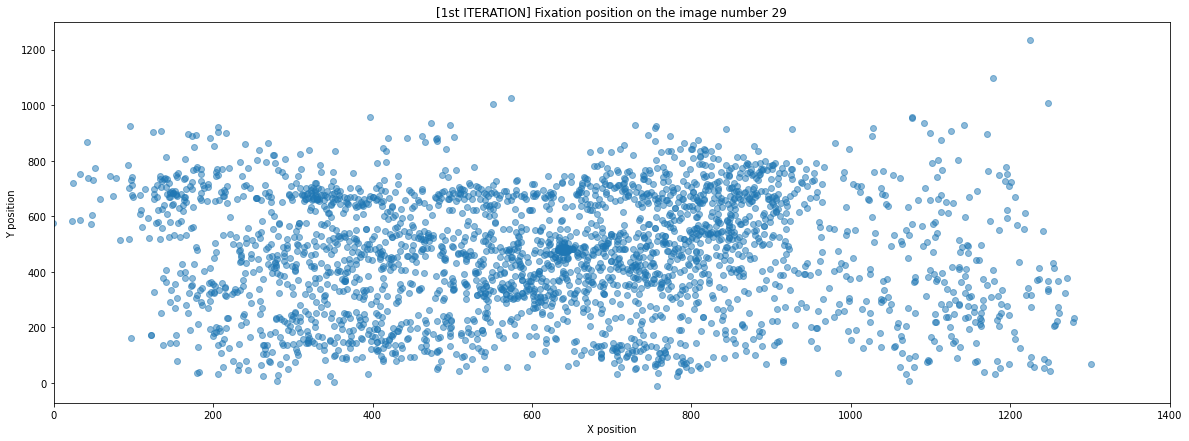

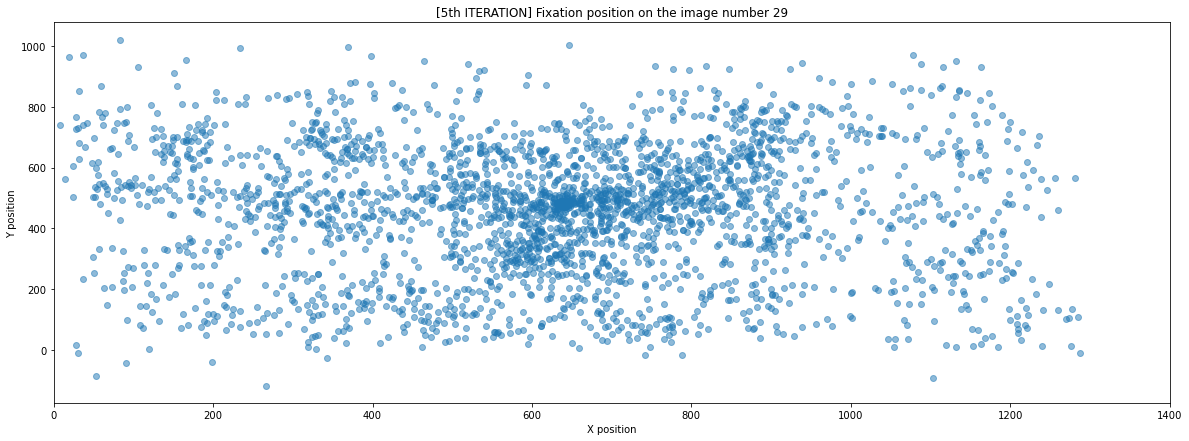

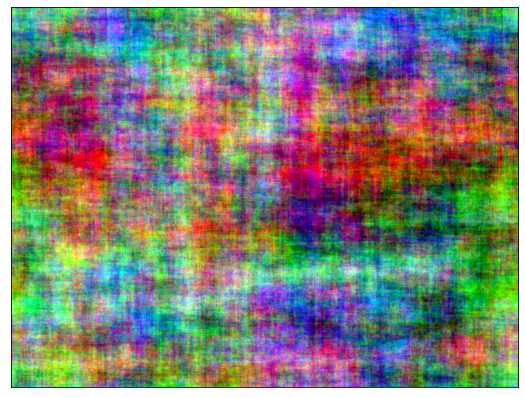

In [56]:
fig, axs = plt.subplots(1, 1 , figsize=(20, 7), sharey=True, sharex=False)
# plt.plot(endx1, endy1) 
plt.scatter(endx1, endy1, alpha=0.5)
plt.title('[1st ITERATION] Fixation position on the image number 29')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1400)
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=True, sharex=True)
# plt.plot(endx5, endy5) 
plt.scatter(endx5, endy5, alpha=0.5)
plt.title('[5th ITERATION] Fixation position on the image number 29')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.xlim(0,1400)
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20, 7), sharey=False, sharex=False)
img = mpimg.imread('11_29.png')
imgplot = plt.imshow(img)
plt.xticks([]) 
plt.yticks([]) 
plt.show()

We have a very huge number of fixations, that almost concentrate themselves... in the whole image.

What can we say?
* The huge number of fixations tell us that the file number '29' is an image full of details and also not so clear...that requires strong concentration of the participants to understand and memorize it
* And the distribution of the fixations, almost on the entire image, confirms our hypothesis.

Clustering will help us and will give us more accurate information about the area of interest!